In [32]:
from SRCNN_different_specs import RunSRCNN, SRCNN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
from torch import nn
import image_patches
import numpy as np

In [33]:
import random

# Seed for reproducibility
seed = 42  # You can use any seed value

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python's random module
random.seed(seed)

In [3]:
TRAIN_DATASET_NAME = "./datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "./datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"
PATCH_SIZE = 33

SCALE_FACTOR = 4

EPOCHS = 150

PATCHES_PER_IMAGE_TRAIN = 80 #####
# PATCHES_PER_IMAGE_TRAIN = 10
PATCHES_PER_IMAGE_VALIDATION = 80 #####
# PATCHES_PER_IMAGE_VALIDATION = 3 
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ./datasets/TRAIN_Flick2k_DIV2K/_33_33_number=80
VALIDATION_DATA_PATH = ./datasets/VALIDATION_Flickr2K_DIV2K/_33_33_number=80


In [4]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [5]:
%%time
transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    transforms.Resize((PATCH_SIZE, PATCH_SIZE), interpolation=Image.BICUBIC)
    # transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # transforms.Resize((33, 33), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ./datasets/TRAIN_Flick2k_DIV2K/_33_33_number=80


100%|██████████| 2920/2920 [00:12<00:00, 239.80it/s]


Creating Dataset based on folder: ./datasets/TRAIN_Flick2k_DIV2K/_33_33_number=80
Creating Dataset based on folder: ./datasets/VALIDATION_Flickr2K_DIV2K/_33_33_number=80


100%|██████████| 630/630 [00:02<00:00, 241.11it/s]


Creating Dataset based on folder: ./datasets/VALIDATION_Flickr2K_DIV2K/_33_33_number=80
Training set has 97785 instances
Validation set has 21091 instances
CPU times: user 15 s, sys: 2.6 s, total: 17.6 s
Wall time: 17.6 s


In [6]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1.25*(2**12))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.37 s, sys: 271 ms, total: 1.64 s
Wall time: 1.64 s


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-3

model_f2_5 = SRCNN(f2=5).to(device)
optimizer_f2_5 = torch.optim.Adam(model_f2_5.parameters(), lr=lr)
scheduler_f2_5 = torch.optim.lr_scheduler.LinearLR(
    optimizer_f2_5,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=60)

model_f2_1 = SRCNN(f2=1).to(device)
optimizer_f2_1 = torch.optim.Adam(model_f2_1.parameters(), lr=lr)
scheduler_f2_1 = torch.optim.lr_scheduler.LinearLR(
    optimizer_f2_1,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=60)


In [8]:
run_srcnn = RunSRCNN()

In [10]:
%%time
run_srcnn.train(
    model=model_f2_1,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer_f2_1,
    epochs=EPOCHS,
    scheduler=scheduler_f2_1,
    loss_fn=nn.MSELoss(),
)


epoch 0
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


  0%|          | 0/10 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


Training Error: 
 Avg loss: 0.091605 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.055305 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009835

epoch 1
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.047799 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.039259 

Learning rate (antes): 0.0009835
Learning rate (depois): 0.000967

epoch 2
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.037709 



100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Validation Error: 
 Avg loss: 0.032023 

Learning rate (antes): 0.000967
Learning rate (depois): 0.0009505

epoch 3
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Training Error: 
 Avg loss: 0.030513 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.025324 

Learning rate (antes): 0.0009505
Learning rate (depois): 0.0009339999999999999

epoch 4
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.024245 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.020565 

Learning rate (antes): 0.0009339999999999999
Learning rate (depois): 0.0009174999999999999

epoch 5
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.020347 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.017863 

Learning rate (antes): 0.0009174999999999999
Learning rate (depois): 0.0009009999999999999

epoch 6
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Training Error: 
 Avg loss: 0.018237 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.016472 

Learning rate (antes): 0.0009009999999999999
Learning rate (depois): 0.0008844999999999999

epoch 7
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.016928 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.015450 

Learning rate (antes): 0.0008844999999999999
Learning rate (depois): 0.0008679999999999998

epoch 8
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.015980 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.014783 

Learning rate (antes): 0.0008679999999999998
Learning rate (depois): 0.0008514999999999998

epoch 9
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.015384 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.014327 

Learning rate (antes): 0.0008514999999999998
Learning rate (depois): 0.0008349999999999998

epoch 10
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.014914 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.013939 

Learning rate (antes): 0.0008349999999999998
Learning rate (depois): 0.0008184999999999998

epoch 11
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.014562 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.013621 

Learning rate (antes): 0.0008184999999999998
Learning rate (depois): 0.0008019999999999998

epoch 12
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.014237 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.013343 

Learning rate (antes): 0.0008019999999999998
Learning rate (depois): 0.0007854999999999997

epoch 13
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.013969 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.013112 

Learning rate (antes): 0.0007854999999999997
Learning rate (depois): 0.0007689999999999997

epoch 14
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.013753 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.012910 

Learning rate (antes): 0.0007689999999999997
Learning rate (depois): 0.0007524999999999997

epoch 15
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.013555 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.012755 

Learning rate (antes): 0.0007524999999999997
Learning rate (depois): 0.0007359999999999997

epoch 16
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.013394 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.012620 

Learning rate (antes): 0.0007359999999999997
Learning rate (depois): 0.0007194999999999997

epoch 17
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.013269 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.012502 

Learning rate (antes): 0.0007194999999999997
Learning rate (depois): 0.0007029999999999996

epoch 18
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.013152 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.012389 

Learning rate (antes): 0.0007029999999999996
Learning rate (depois): 0.0006864999999999997

epoch 19
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.013003 



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation Error: 
 Avg loss: 0.012259 

Learning rate (antes): 0.0006864999999999997
Learning rate (depois): 0.0006699999999999997

epoch 20
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.012884 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.012152 

Learning rate (antes): 0.0006699999999999997
Learning rate (depois): 0.0006534999999999998

epoch 21
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.012765 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.012049 

Learning rate (antes): 0.0006534999999999998
Learning rate (depois): 0.0006369999999999998

epoch 22
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


Training Error: 
 Avg loss: 0.012648 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.011957 

Learning rate (antes): 0.0006369999999999998
Learning rate (depois): 0.0006204999999999997

epoch 23
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.012565 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.011860 

Learning rate (antes): 0.0006204999999999997
Learning rate (depois): 0.0006039999999999997

epoch 24
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.012447 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.011778 

Learning rate (antes): 0.0006039999999999997
Learning rate (depois): 0.0005874999999999997

epoch 25
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.012368 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.011673 

Learning rate (antes): 0.0005874999999999997
Learning rate (depois): 0.0005709999999999998

epoch 26
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.012263 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.011596 

Learning rate (antes): 0.0005709999999999998
Learning rate (depois): 0.0005544999999999998

epoch 27
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.012166 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.011520 

Learning rate (antes): 0.0005544999999999998
Learning rate (depois): 0.0005379999999999997

epoch 28
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.012102 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.011448 

Learning rate (antes): 0.0005379999999999997
Learning rate (depois): 0.0005214999999999997

epoch 29
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.012040 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.011396 

Learning rate (antes): 0.0005214999999999997
Learning rate (depois): 0.0005049999999999997

epoch 30
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011970 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.011333 

Learning rate (antes): 0.0005049999999999997
Learning rate (depois): 0.0004884999999999997

epoch 31
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011901 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.011285 

Learning rate (antes): 0.0004884999999999997
Learning rate (depois): 0.0004719999999999997

epoch 32
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011871 



100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Validation Error: 
 Avg loss: 0.011239 

Learning rate (antes): 0.0004719999999999997
Learning rate (depois): 0.00045549999999999974

epoch 33
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011814 



100%|██████████| 3/3 [00:05<00:00,  1.98s/it]


Validation Error: 
 Avg loss: 0.011196 

Learning rate (antes): 0.00045549999999999974
Learning rate (depois): 0.0004389999999999998

epoch 34
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011771 



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation Error: 
 Avg loss: 0.011160 

Learning rate (antes): 0.0004389999999999998
Learning rate (depois): 0.00042249999999999975

epoch 35
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011738 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.011122 

Learning rate (antes): 0.00042249999999999975
Learning rate (depois): 0.0004059999999999998

epoch 36
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011698 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.011089 

Learning rate (antes): 0.0004059999999999998
Learning rate (depois): 0.0003894999999999998

epoch 37
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011652 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.011060 

Learning rate (antes): 0.0003894999999999998
Learning rate (depois): 0.00037299999999999985

epoch 38
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011618 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.011030 

Learning rate (antes): 0.00037299999999999985
Learning rate (depois): 0.00035649999999999983

epoch 39
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011588 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.011004 

Learning rate (antes): 0.00035649999999999983
Learning rate (depois): 0.0003399999999999998

epoch 40
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011571 



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation Error: 
 Avg loss: 0.010981 

Learning rate (antes): 0.0003399999999999998
Learning rate (depois): 0.0003234999999999998

epoch 41
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011539 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010956 

Learning rate (antes): 0.0003234999999999998
Learning rate (depois): 0.00030699999999999976

epoch 42
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Training Error: 
 Avg loss: 0.011528 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010935 

Learning rate (antes): 0.00030699999999999976
Learning rate (depois): 0.00029049999999999974

epoch 43
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011506 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010914 

Learning rate (antes): 0.00029049999999999974
Learning rate (depois): 0.0002739999999999998

epoch 44
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011477 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010893 

Learning rate (antes): 0.0002739999999999998
Learning rate (depois): 0.0002574999999999998

epoch 45
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011456 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010875 

Learning rate (antes): 0.0002574999999999998
Learning rate (depois): 0.0002409999999999998

epoch 46
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


Training Error: 
 Avg loss: 0.011444 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010861 

Learning rate (antes): 0.0002409999999999998
Learning rate (depois): 0.00022449999999999982

epoch 47
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011423 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010844 

Learning rate (antes): 0.00022449999999999982
Learning rate (depois): 0.00020799999999999982

epoch 48
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011403 



100%|██████████| 3/3 [00:05<00:00,  1.98s/it]


Validation Error: 
 Avg loss: 0.010831 

Learning rate (antes): 0.00020799999999999982
Learning rate (depois): 0.00019149999999999986

epoch 49
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011387 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010817 

Learning rate (antes): 0.00019149999999999986
Learning rate (depois): 0.00017499999999999986

epoch 50
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011376 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010806 

Learning rate (antes): 0.00017499999999999986
Learning rate (depois): 0.00015849999999999987

epoch 51
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011367 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010796 

Learning rate (antes): 0.00015849999999999987
Learning rate (depois): 0.00014199999999999987

epoch 52
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011363 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010787 

Learning rate (antes): 0.00014199999999999987
Learning rate (depois): 0.0001254999999999999

epoch 53
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011341 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010779 

Learning rate (antes): 0.0001254999999999999
Learning rate (depois): 0.00010899999999999993

epoch 54
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011338 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010772 

Learning rate (antes): 0.00010899999999999993
Learning rate (depois): 9.249999999999994e-05

epoch 55
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011325 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010767 

Learning rate (antes): 9.249999999999994e-05
Learning rate (depois): 7.599999999999995e-05

epoch 56
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011332 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010761 

Learning rate (antes): 7.599999999999995e-05
Learning rate (depois): 5.949999999999996e-05

epoch 57
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011338 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010758 

Learning rate (antes): 5.949999999999996e-05
Learning rate (depois): 4.299999999999998e-05

epoch 58
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011314 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010755 

Learning rate (antes): 4.299999999999998e-05
Learning rate (depois): 2.6499999999999977e-05

epoch 59
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011301 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010753 

Learning rate (antes): 2.6499999999999977e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 60
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011310 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010752 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 61
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011307 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010752 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 62
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Training Error: 
 Avg loss: 0.011307 



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation Error: 
 Avg loss: 0.010751 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 63
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011313 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010750 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 64
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011307 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010750 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 65
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011308 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010749 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 66
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011312 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010748 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 67
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011313 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010748 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 68
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011302 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010747 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 69
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011305 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010746 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 70
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011297 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010746 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 71
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011299 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010745 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 72
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011304 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010744 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 73
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011300 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010743 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 74
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011301 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010743 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 75
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011302 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010742 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 76
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011302 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010741 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 77
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011303 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010740 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 78
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011298 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010740 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 79
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011307 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010739 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 80
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011302 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010738 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 81
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011305 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010738 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 82
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011300 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010737 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 83
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011301 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010736 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 84
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011288 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010735 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 85
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011282 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010735 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 86
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011305 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010734 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 87
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011303 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010733 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 88
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011284 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010732 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 89
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011295 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010731 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 90
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Training Error: 
 Avg loss: 0.011292 



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation Error: 
 Avg loss: 0.010731 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 91
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011284 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010730 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 92
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011298 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010729 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 93
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011296 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010728 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 94
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011281 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010727 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 95
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011293 



100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Validation Error: 
 Avg loss: 0.010727 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 96
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011297 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010726 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 97
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011287 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010725 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 98
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011277 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010724 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 99
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011281 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010723 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 100
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011282 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010722 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 101
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011287 



100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Validation Error: 
 Avg loss: 0.010722 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 102
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011281 



100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Validation Error: 
 Avg loss: 0.010721 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 103
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011278 



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation Error: 
 Avg loss: 0.010720 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 104
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011281 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010719 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 105
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011272 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010718 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 106
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011277 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010717 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 107
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011272 



100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Validation Error: 
 Avg loss: 0.010717 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 108
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Training Error: 
 Avg loss: 0.011274 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010716 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 109
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011275 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010715 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 110
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011274 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010714 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 111
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011263 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010713 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 112
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011270 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010712 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 113
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011271 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010711 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 114
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011260 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010710 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 115
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011261 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010710 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 116
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


Training Error: 
 Avg loss: 0.011272 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010709 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 117
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011278 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010708 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 118
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011255 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 119
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011260 



100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Validation Error: 
 Avg loss: 0.010706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 120
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011265 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 121
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011271 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010704 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 122
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011255 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010703 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 123
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011262 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010702 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 124
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


Training Error: 
 Avg loss: 0.011260 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010701 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 125
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Training Error: 
 Avg loss: 0.011258 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010700 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 126
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011249 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010699 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 127
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011248 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010699 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 128
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011254 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010698 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 129
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011251 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010697 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 130
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011247 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010696 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 131
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011256 



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation Error: 
 Avg loss: 0.010695 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 132
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011243 



100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010694 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 133
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011265 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010693 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 134
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011254 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010692 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 135
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011248 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010691 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 136
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011257 



100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Validation Error: 
 Avg loss: 0.010690 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 137
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011243 



100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


Validation Error: 
 Avg loss: 0.010689 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 138
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011242 



100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Validation Error: 
 Avg loss: 0.010688 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 139
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011243 



100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Error: 
 Avg loss: 0.010687 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 140
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011245 



100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Validation Error: 
 Avg loss: 0.010686 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 141
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Training Error: 
 Avg loss: 0.011238 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010685 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 142
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011248 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010684 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 143
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011233 



100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Validation Error: 
 Avg loss: 0.010683 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 144
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011244 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010682 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 145
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011243 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010681 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 146
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Training Error: 
 Avg loss: 0.011242 



100%|██████████| 3/3 [00:05<00:00,  1.96s/it]


Validation Error: 
 Avg loss: 0.010680 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 147
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.011227 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validation Error: 
 Avg loss: 0.010679 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 148
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


Training Error: 
 Avg loss: 0.011237 



100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Validation Error: 
 Avg loss: 0.010678 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 149
-------------------------------
Training on 97785 samples...
Batch size: 10240
Number of batches: 10


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


Training Error: 
 Avg loss: 0.011226 



100%|██████████| 3/3 [00:06<00:00,  2.04s/it]

Validation Error: 
 Avg loss: 0.010677 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05
CPU times: user 1h 35min 53s, sys: 3min 16s, total: 1h 39min 10s
Wall time: 1h 37min 19s


In [11]:
df_f2_1 = run_srcnn.get_model_df()
df_f2_1.tail()

,epoch,time,lr,train_loss,validation_loss
145,145,38.831953,0.00001,0.011243,0.010681
146,146,38.991763,0.00001,0.011242,0.010680
147,147,38.993675,0.00001,0.011227,0.010679
148,148,39.068824,0.00001,0.011237,0.010678
149,149,38.952376,0.00001,0.011226,0.010677


In [12]:
# run_srcnn.save_model_df('./results/srcnn-tecgraf/dataframes/model_f2_1.csv')
# run_srcnn.save_model_weights(model_f2_1, './results/srcnn-tecgraf/trained_weights/model_f2_1.pth')

In [9]:
%%time

run_srcnn.clear_all()

run_srcnn.train(
    model=model_f2_5,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer_f2_5,
    epochs=EPOCHS,
    scheduler=scheduler_f2_5,
    loss_fn=nn.MSELoss(),
)


epoch 0
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


  0%|          | 0/20 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


Training Error: 
 Avg loss: 0.080201 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.031272 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009835

epoch 1
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.025180 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.017486 

Learning rate (antes): 0.0009835
Learning rate (depois): 0.000967

epoch 2
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.015407 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.012947 

Learning rate (antes): 0.000967
Learning rate (depois): 0.0009505

epoch 3
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.012859 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.011731 

Learning rate (antes): 0.0009505
Learning rate (depois): 0.0009339999999999999

epoch 4
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.011835 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.011004 

Learning rate (antes): 0.0009339999999999999
Learning rate (depois): 0.0009174999999999999

epoch 5
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.011309 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010750 

Learning rate (antes): 0.0009174999999999999
Learning rate (depois): 0.0009009999999999999

epoch 6
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.011101 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.010579 

Learning rate (antes): 0.0009009999999999999
Learning rate (depois): 0.0008844999999999999

epoch 7
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010975 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.010471 

Learning rate (antes): 0.0008844999999999999
Learning rate (depois): 0.0008679999999999998

epoch 8
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010831 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010365 

Learning rate (antes): 0.0008679999999999998
Learning rate (depois): 0.0008514999999999998

epoch 9
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010767 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.010302 

Learning rate (antes): 0.0008514999999999998
Learning rate (depois): 0.0008349999999999998

epoch 10
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010696 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010275 

Learning rate (antes): 0.0008349999999999998
Learning rate (depois): 0.0008184999999999998

epoch 11
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010631 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.010194 

Learning rate (antes): 0.0008184999999999998
Learning rate (depois): 0.0008019999999999998

epoch 12
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010618 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010180 

Learning rate (antes): 0.0008019999999999998
Learning rate (depois): 0.0007854999999999997

epoch 13
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010513 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010115 

Learning rate (antes): 0.0007854999999999997
Learning rate (depois): 0.0007689999999999997

epoch 14
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010457 



100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010076 

Learning rate (antes): 0.0007689999999999997
Learning rate (depois): 0.0007524999999999997

epoch 15
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010531 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010200 

Learning rate (antes): 0.0007524999999999997
Learning rate (depois): 0.0007359999999999997

epoch 16
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010450 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010041 

Learning rate (antes): 0.0007359999999999997
Learning rate (depois): 0.0007194999999999997

epoch 17
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010375 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.010001 

Learning rate (antes): 0.0007194999999999997
Learning rate (depois): 0.0007029999999999996

epoch 18
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010391 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009976 

Learning rate (antes): 0.0007029999999999996
Learning rate (depois): 0.0006864999999999997

epoch 19
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010346 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009975 

Learning rate (antes): 0.0006864999999999997
Learning rate (depois): 0.0006699999999999997

epoch 20
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010349 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009933 

Learning rate (antes): 0.0006699999999999997
Learning rate (depois): 0.0006534999999999998

epoch 21
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010283 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009921 

Learning rate (antes): 0.0006534999999999998
Learning rate (depois): 0.0006369999999999998

epoch 22
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010290 



100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Validation Error: 
 Avg loss: 0.009940 

Learning rate (antes): 0.0006369999999999998
Learning rate (depois): 0.0006204999999999997

epoch 23
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010285 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009891 

Learning rate (antes): 0.0006204999999999997
Learning rate (depois): 0.0006039999999999997

epoch 24
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010266 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009868 

Learning rate (antes): 0.0006039999999999997
Learning rate (depois): 0.0005874999999999997

epoch 25
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010250 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009861 

Learning rate (antes): 0.0005874999999999997
Learning rate (depois): 0.0005709999999999998

epoch 26
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010210 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009851 

Learning rate (antes): 0.0005709999999999998
Learning rate (depois): 0.0005544999999999998

epoch 27
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010191 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009844 

Learning rate (antes): 0.0005544999999999998
Learning rate (depois): 0.0005379999999999997

epoch 28
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010239 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009837 

Learning rate (antes): 0.0005379999999999997
Learning rate (depois): 0.0005214999999999997

epoch 29
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010255 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009837 

Learning rate (antes): 0.0005214999999999997
Learning rate (depois): 0.0005049999999999997

epoch 30
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010186 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009810 

Learning rate (antes): 0.0005049999999999997
Learning rate (depois): 0.0004884999999999997

epoch 31
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010186 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009802 

Learning rate (antes): 0.0004884999999999997
Learning rate (depois): 0.0004719999999999997

epoch 32
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010184 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009797 

Learning rate (antes): 0.0004719999999999997
Learning rate (depois): 0.00045549999999999974

epoch 33
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010182 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009788 

Learning rate (antes): 0.00045549999999999974
Learning rate (depois): 0.0004389999999999998

epoch 34
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010153 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009782 

Learning rate (antes): 0.0004389999999999998
Learning rate (depois): 0.00042249999999999975

epoch 35
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010149 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009778 

Learning rate (antes): 0.00042249999999999975
Learning rate (depois): 0.0004059999999999998

epoch 36
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010140 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009770 

Learning rate (antes): 0.0004059999999999998
Learning rate (depois): 0.0003894999999999998

epoch 37
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010114 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009766 

Learning rate (antes): 0.0003894999999999998
Learning rate (depois): 0.00037299999999999985

epoch 38
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010076 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009758 

Learning rate (antes): 0.00037299999999999985
Learning rate (depois): 0.00035649999999999983

epoch 39
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010110 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009764 

Learning rate (antes): 0.00035649999999999983
Learning rate (depois): 0.0003399999999999998

epoch 40
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010092 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009751 

Learning rate (antes): 0.0003399999999999998
Learning rate (depois): 0.0003234999999999998

epoch 41
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010116 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009750 

Learning rate (antes): 0.0003234999999999998
Learning rate (depois): 0.00030699999999999976

epoch 42
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010095 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009742 

Learning rate (antes): 0.00030699999999999976
Learning rate (depois): 0.00029049999999999974

epoch 43
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010145 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009736 

Learning rate (antes): 0.00029049999999999974
Learning rate (depois): 0.0002739999999999998

epoch 44
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010109 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009741 

Learning rate (antes): 0.0002739999999999998
Learning rate (depois): 0.0002574999999999998

epoch 45
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010101 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009731 

Learning rate (antes): 0.0002574999999999998
Learning rate (depois): 0.0002409999999999998

epoch 46
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010077 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009728 

Learning rate (antes): 0.0002409999999999998
Learning rate (depois): 0.00022449999999999982

epoch 47
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010074 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009724 

Learning rate (antes): 0.00022449999999999982
Learning rate (depois): 0.00020799999999999982

epoch 48
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010083 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009721 

Learning rate (antes): 0.00020799999999999982
Learning rate (depois): 0.00019149999999999986

epoch 49
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010067 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009723 

Learning rate (antes): 0.00019149999999999986
Learning rate (depois): 0.00017499999999999986

epoch 50
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010124 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009721 

Learning rate (antes): 0.00017499999999999986
Learning rate (depois): 0.00015849999999999987

epoch 51
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010099 



100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Error: 
 Avg loss: 0.009717 

Learning rate (antes): 0.00015849999999999987
Learning rate (depois): 0.00014199999999999987

epoch 52
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010077 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009715 

Learning rate (antes): 0.00014199999999999987
Learning rate (depois): 0.0001254999999999999

epoch 53
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010059 



100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Error: 
 Avg loss: 0.009712 

Learning rate (antes): 0.0001254999999999999
Learning rate (depois): 0.00010899999999999993

epoch 54
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010072 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009711 

Learning rate (antes): 0.00010899999999999993
Learning rate (depois): 9.249999999999994e-05

epoch 55
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010061 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009710 

Learning rate (antes): 9.249999999999994e-05
Learning rate (depois): 7.599999999999995e-05

epoch 56
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Training Error: 
 Avg loss: 0.010049 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009709 

Learning rate (antes): 7.599999999999995e-05
Learning rate (depois): 5.949999999999996e-05

epoch 57
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010125 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009710 

Learning rate (antes): 5.949999999999996e-05
Learning rate (depois): 4.299999999999998e-05

epoch 58
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Training Error: 
 Avg loss: 0.010074 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009708 

Learning rate (antes): 4.299999999999998e-05
Learning rate (depois): 2.6499999999999977e-05

epoch 59
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010058 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009708 

Learning rate (antes): 2.6499999999999977e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 60
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Training Error: 
 Avg loss: 0.010087 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 61
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010036 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 62
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010037 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 63
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010085 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 64
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010041 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 65
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010058 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 66
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010039 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 67
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010114 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 68
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010048 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009707 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 69
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010062 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 70
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010031 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 71
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010039 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 72
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010059 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 73
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010066 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 74
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010043 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 75
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010069 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 76
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010079 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009706 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 77
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010089 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 78
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010046 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 79
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010057 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 80
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010045 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 81
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010025 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 82
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010092 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 83
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010092 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 84
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010056 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009705 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 85
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Training Error: 
 Avg loss: 0.010042 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009704 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 86
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010087 



100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Error: 
 Avg loss: 0.009704 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 87
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010099 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009704 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 88
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010055 



100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Error: 
 Avg loss: 0.009704 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 89
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010033 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009704 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 90
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010067 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009704 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 91
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010071 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009704 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 92
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010064 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009703 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 93
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010114 



100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Validation Error: 
 Avg loss: 0.009703 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 94
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010036 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009703 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 95
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010077 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009703 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 96
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010077 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009703 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 97
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010079 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009703 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 98
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010057 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009702 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 99
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010010 



100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Error: 
 Avg loss: 0.009702 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 100
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010093 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009702 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 101
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010057 



100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Error: 
 Avg loss: 0.009702 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 102
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010071 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009702 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 103
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010070 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009702 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 104
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010059 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009701 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 105
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010069 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009701 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 106
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010050 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009701 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 107
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010055 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009701 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 108
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010035 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009701 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 109
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010056 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009701 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 110
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010040 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009701 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 111
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010055 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009700 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 112
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010056 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009700 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 113
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010074 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009700 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 114
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010052 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009700 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 115
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010092 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009700 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 116
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010038 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009699 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 117
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010104 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009699 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 118
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010021 



100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Validation Error: 
 Avg loss: 0.009699 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 119
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010029 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009699 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 120
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010078 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009699 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 121
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010106 



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.009699 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 122
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010059 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009698 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 123
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010048 



100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009698 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 124
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010057 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009698 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 125
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010032 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009698 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 126
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010054 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009698 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 127
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010020 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009698 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 128
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010060 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009697 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 129
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010065 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009697 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 130
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010032 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009697 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 131
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010057 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009697 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 132
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010035 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009697 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 133
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010059 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009696 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 134
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010048 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009696 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 135
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010058 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009696 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 136
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010091 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009696 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 137
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010037 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009695 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 138
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010051 



100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Validation Error: 
 Avg loss: 0.009695 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 139
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010062 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009695 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 140
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010094 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009695 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 141
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010037 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009695 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 142
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010097 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009694 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 143
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010063 



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009694 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 144
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Training Error: 
 Avg loss: 0.010082 



100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


Validation Error: 
 Avg loss: 0.009694 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 145
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010060 



100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Validation Error: 
 Avg loss: 0.009694 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 146
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010059 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Validation Error: 
 Avg loss: 0.009694 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 147
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Training Error: 
 Avg loss: 0.010049 



100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Error: 
 Avg loss: 0.009693 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 148
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Training Error: 
 Avg loss: 0.010104 



100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.009693 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05

epoch 149
-------------------------------
Training on 97785 samples...
Batch size: 5120
Number of batches: 20


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Training Error: 
 Avg loss: 0.010058 



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]

Validation Error: 
 Avg loss: 0.009693 

Learning rate (antes): 1.0000000000000028e-05
Learning rate (depois): 1.0000000000000028e-05
CPU times: user 1h 35min 20s, sys: 3min 13s, total: 1h 38min 33s
Wall time: 1h 36min 46s


In [10]:
df_f2_5 = run_srcnn.get_model_df()
df_f2_5.tail()

,epoch,time,lr,train_loss,validation_loss
145,145,39.037024,0.00001,0.010060,0.009694
146,146,39.076534,0.00001,0.010059,0.009694
147,147,38.598171,0.00001,0.010049,0.009693
148,148,38.950287,0.00001,0.010104,0.009693
149,149,38.553115,0.00001,0.010058,0.009693


In [20]:
# run_srcnn.save_model_df('./results/srcnn-tecgraf/dataframes/model_f2_5.csv')
# run_srcnn.save_model_weights(model_f2_5, './results/srcnn-tecgraf/trained_weights/model_f2_5.pth')

In [30]:
model_f2_1_test = SRCNN(f2=1).to(device)
model_f2_1_test.load_state_dict(torch.load('./results/srcnn-tecgraf/trained_weights/model_f2_1.pth', map_location=torch.device('cpu')))

model_f2_5_test = SRCNN(f2=5).to(device)
model_f2_5_test.load_state_dict(torch.load('./results/srcnn-tecgraf/trained_weights/model_f2_5.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
path = f"./datasets/BSDS100/"
# path = f"{DATASET_ROOT}/Set14"
from model_runner import ModelRunner
model_runner = ModelRunner()
model_runner.compare_models([
                              {"name": "model_f2_1_test", "model": model_f2_1_test, "scale": 4}, 
                              {"name": "model_f2_5_test", "model": model_f2_5_test, "scale": 4},
                          ],
                            path, 4)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
model_f2_1_test,23.307922,0.612651
model_f2_5_test,23.501068,0.622676
Bicubic,23.045410,0.632868


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


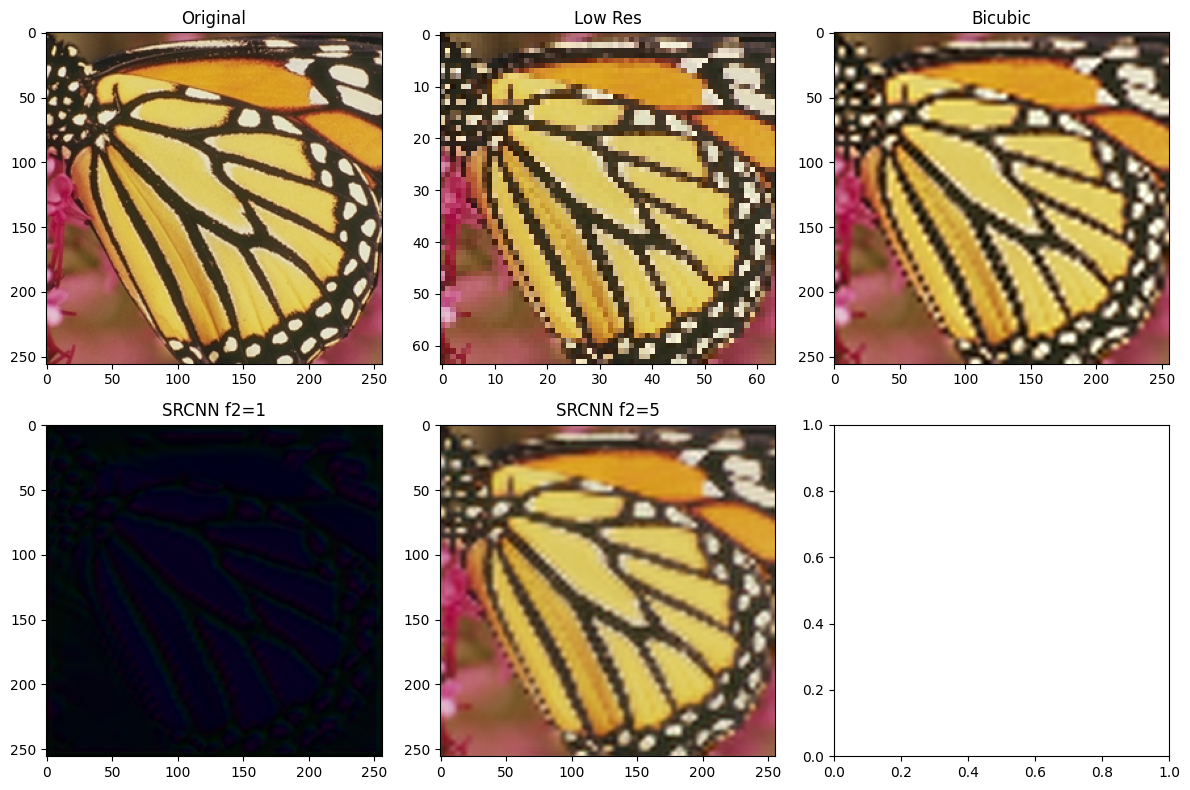

In [14]:
IMAGE_EXAMPLE = "./datasets/Set5/butterfly.png"

from image_helper import ImageHelper
image_helper = ImageHelper()

image_helper.show_tensors_custom_grid(
    tensors = [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        {
            "label": "SRCNN f2=1",
            "tensor": image_helper.apply_model_to_image(
                model_f2_1,
                IMAGE_EXAMPLE,
                4
            )
        },
        {
            "label": "SRCNN f2=5",
            "tensor": image_helper.apply_model_to_image(
                model_f2_5,
                IMAGE_EXAMPLE,
                4
            )
        },
        

        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=dbpn,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "SRGAN",
        #     "tensor": image_helper.apply_model_to_image(
        #         srgan.to('cpu'),
        #         IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True,
        #         device='cpu'
        #     )
        # },
    ],
    rows=2,
    cols=3,
    show_grid=True
)

In [2]:
import pandas as pd
df = pd.read_csv('./results/srcnn-tecgraf/dataframes/model_f2_1.csv')

In [3]:
df

,epoch,time,lr,train_loss,validation_loss
0,0,40.124405,0.000983,0.091605,0.055305
1,1,38.895512,0.000967,0.047799,0.039259
2,2,39.227685,0.000950,0.037709,0.032023
3,3,39.376962,0.000934,0.030513,0.025324
4,4,39.245804,0.000917,0.024245,0.020565
...,...,...,...,...,...
145,145,38.831953,0.000010,0.011243,0.010681
146,146,38.991763,0.000010,0.011242,0.010680
147,147,38.993675,0.000010,0.011227,0.010679
148,148,39.068824,0.000010,0.011237,0.010678
